<a href="https://colab.research.google.com/github/magistery-tps/dm-cyt-tp/blob/main/TP_microestados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import clear_output
import sys
import os.path
from os import path

def is_runing_into_colab_env():
    try:
        import google.colab
        return True
    except:
        return False

# 1. Instalacion de paquetes

Bajo paquete para trabajar con EEG- Me permite ver la topografía

In [3]:
if is_runing_into_colab_env():
    !pip install mne
    !pip install scikit-learn-extra

# 2. Descargar dataset

Se descarga el dataset y lo descomprime en `~/dataset`.

In [4]:
filename     = "procesados-20210908T224817Z-001.zip"
dataset_url  =  f'https://raw.githubusercontent.com/magistery-tps/dm-cyt-tp/main/datasets/{filename}'
dataset_path = "dataset"

if is_runing_into_colab_env():
    !cd ~
    !rm -rf procesados
    !rm -rf dataset
    !rm -rf {filename}
    !wget  {dataset_url}
    !unzip {filename}
    !mv procesados dataset
    !apt install -y tree
    clear_output()
    !tree dataset

# 3. Importa libreria del proyecto

In [5]:
if is_runing_into_colab_env():
    if path.exists('/content/dm-cyt-tp'):
        print('Pull...\n')
        !cd dm-cyt-tp; git pull origin main
    else:
        print('Clone...\n')
        !git clone https://github.com/magistery-tps/dm-cyt-tp.git

In [6]:
sys.path.append('/content/dm-cyt-tp/src' if is_runing_into_colab_env() else './src')

# 4. Importa paquetes externos

In [57]:
import numpy as np
import pandas as pd

from scipy.signal import find_peaks

from sklearn.cluster          import KMeans, DBSCAN   #opcion kmeans y dbscan definir cuales se usan
from sklearn.metrics          import adjusted_rand_score, silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster.hierarchy  import dendrogram, linkage, cophenet, fcluster
from sklearn.preprocessing    import MinMaxScaler

from sklearn_extra.cluster import KMedoids 

from sklearn.manifold      import TSNE, MDS, Isomap, SpectralEmbedding
from sklearn.decomposition import PCA

from plot import plot_gfp, \
                 plot_silhoutte_modificado2, \
                 plot_eeg_pca, \
                 plot_eeg_topology_on_axis, \
                 plot_egg_on_axis, \
                 plot_eegs_summary, \
                 plot_sx_reduce_noise, \
                 plot_maps_pca, \
                 plot_vectores_kmeans, \
                 plot_silhoutte, \
                 plot_dendrogram, \
                 plot_distancia_euclidea, \
                 plot_pca_df

from gfp  import find_gfp_peaks, \
                 show_complete_gfp_peaks_summary, \
                 reduce_noise_pca

from eeg  import get_info_eeg_and_montage, \
                 eegs_total_mean, \
                 order_asc_by_subject, \
                 order_asc_by_resting_state

from gev        import calculo_gev

from clustering import van_dongen, \
                       kmeans2, \
                       silhoutte_modificado2, \
                       calcula_sse_kmedoids

from pca import to_df

from read_eeg  import load_eeg_dataset
from util      import concat_fields, data_field
import mne
import matplotlib.pyplot as plt

El registro de EEG de 30 canales viene en formato txt (cada uno de los canales es una señal de un electrodo). La frecuencia de muestreo de la señal orginal es de 256 Hz, luego fue filtrada y resampleada a 128 Hz.

## 5. Lectura de EEG's

Para cada persona identificada con el número que sigue a "suj_" se hicieron dos registros para cada persona, uno antes de aprender algo "bl_1" y el otro despues de aprender algo "bl_2"

In [9]:
eegs = load_eeg_dataset('./dataset/*')

In [10]:
eegs[1].to_dict()

{'subject': '9',
 'resting_state': '2',
 'nchannels': 30,
 'sfrequency': 128,
 'nsamples': 7681,
 'data': array([[ 6.4596 ,  2.4325 ,  1.7316 , ...,  0.63108, -9.7919 ,  1.8854 ],
        [ 1.7245 , -0.73154, -0.13338, ..., -2.9122 , -3.1555 , -1.8625 ],
        [-2.7028 , -3.5587 , -1.8376 , ..., -6.1657 ,  4.1212 , -5.3844 ],
        ...,
        [-1.4558 , -1.7363 , -6.3833 , ..., -2.8764 ,  3.1372 , -4.9186 ],
        [-1.5864 , -1.5054 , -2.7014 , ..., -2.6479 ,  4.8606 , -5.1937 ],
        [-0.03244, -0.37213,  2.3855 , ..., -2.2923 ,  4.4682 , -4.7686 ]])}

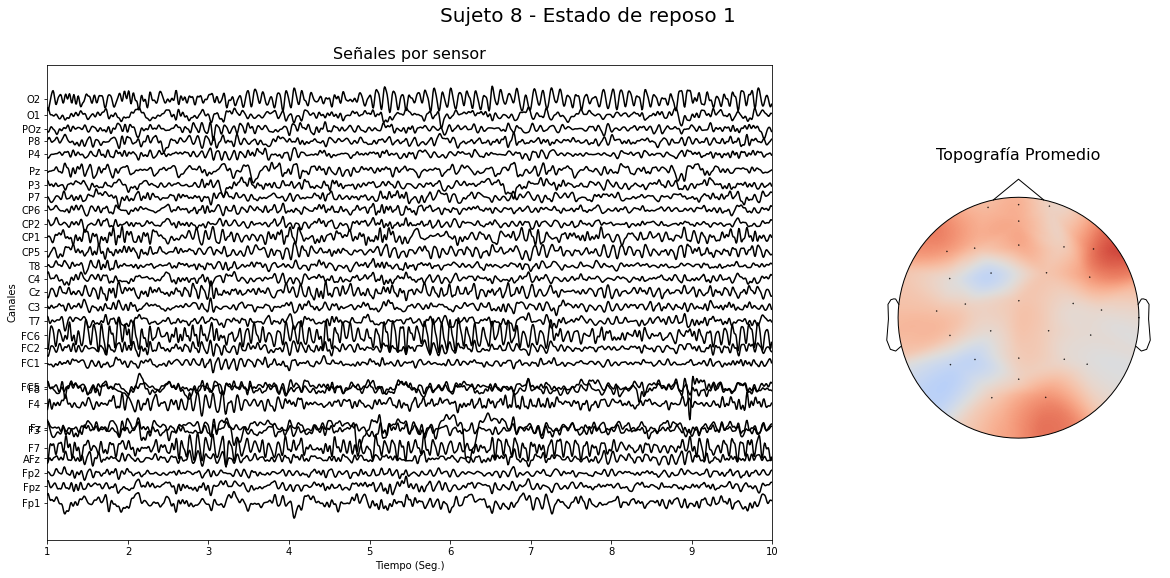

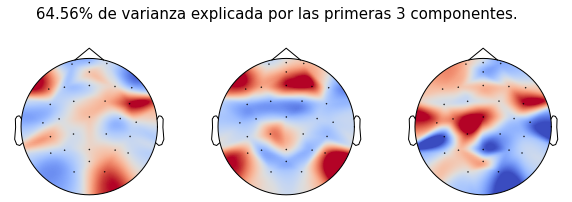

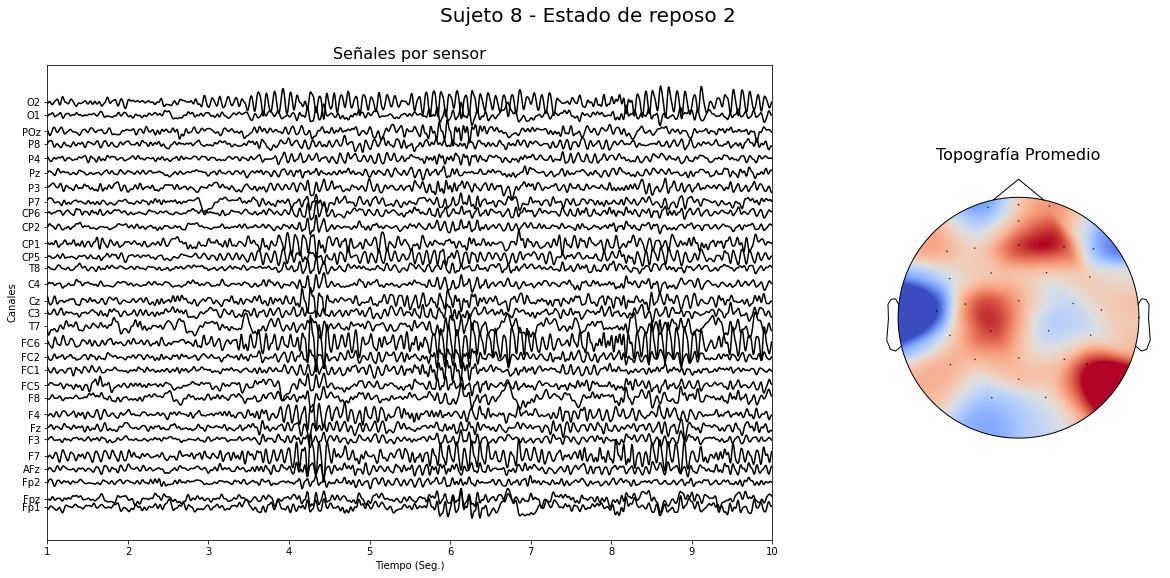

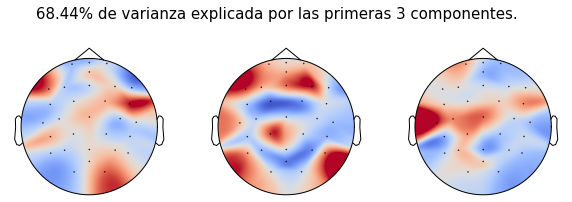

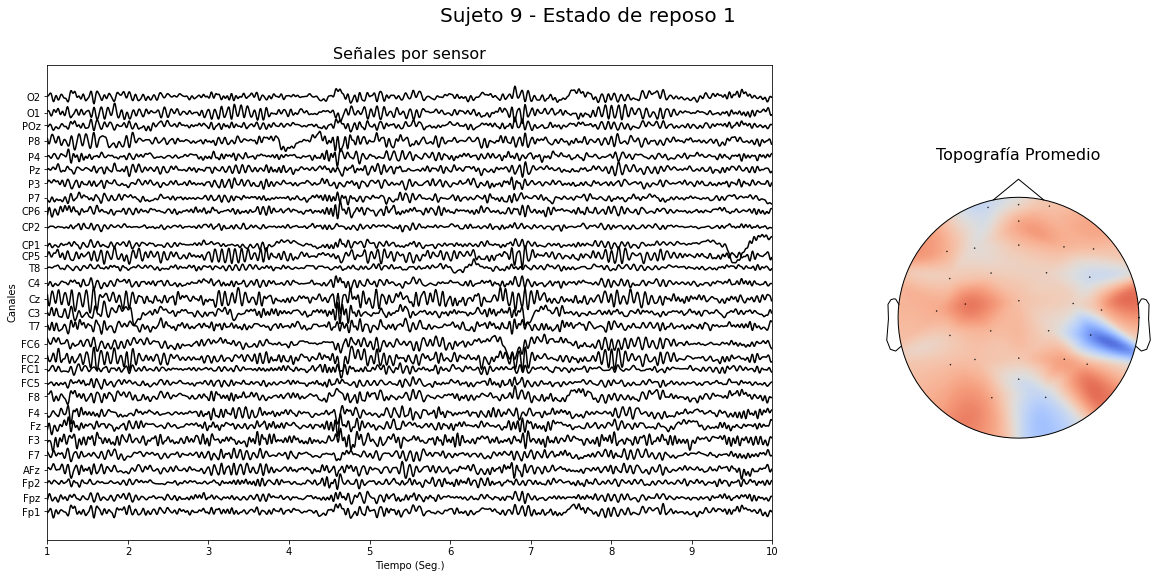

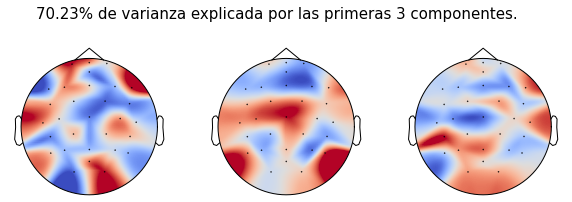

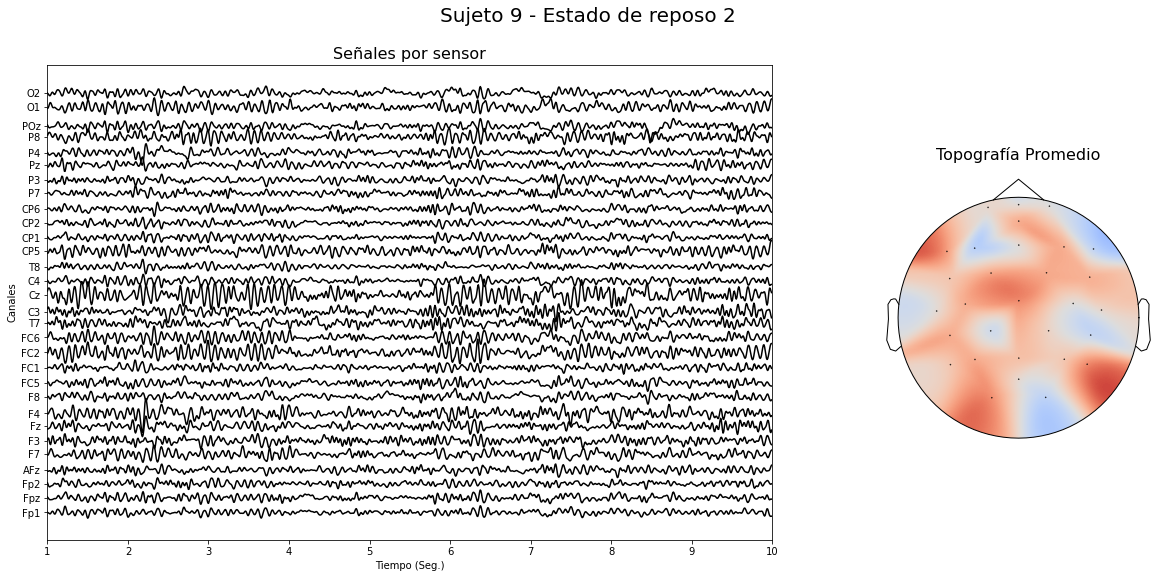

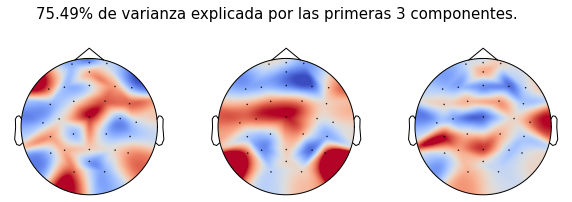

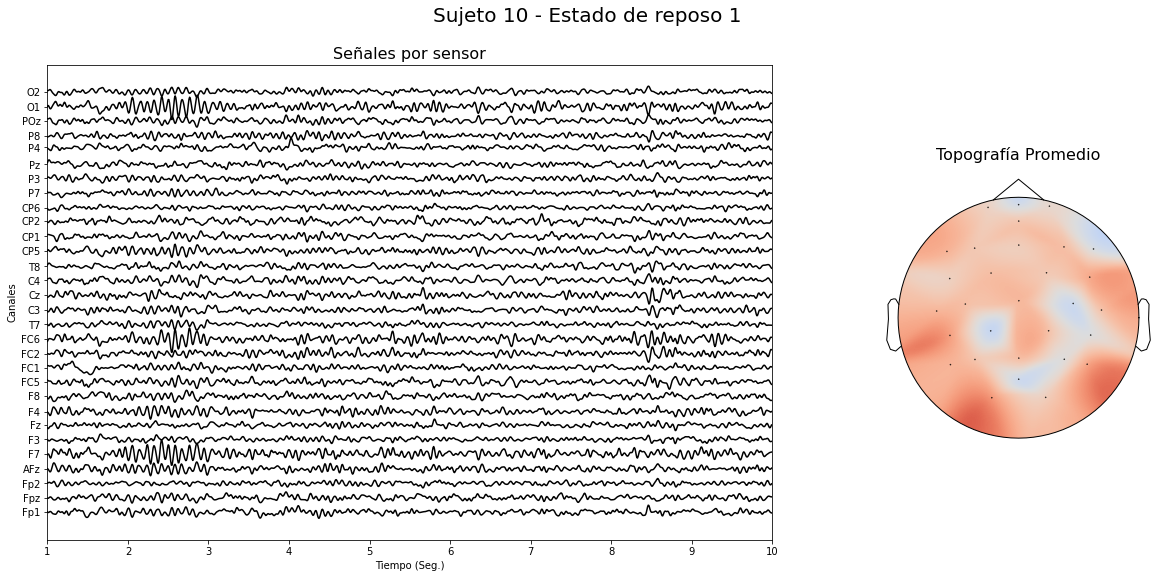

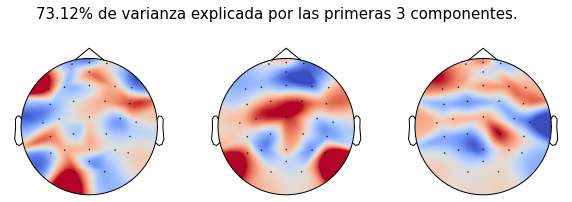

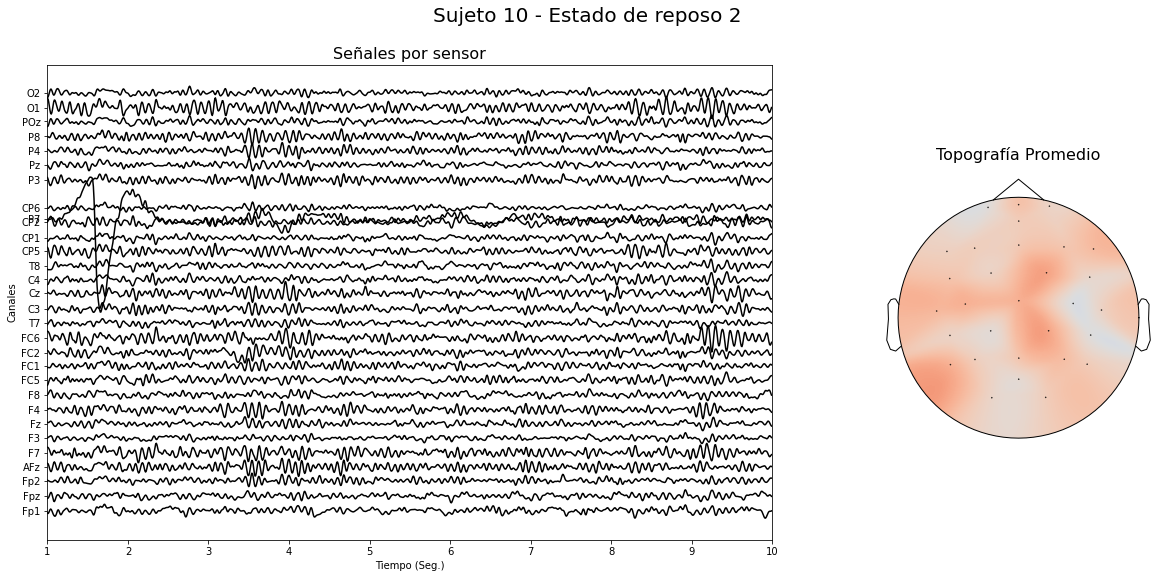

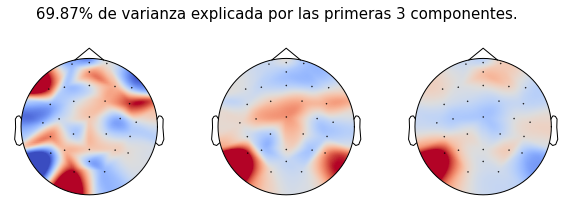

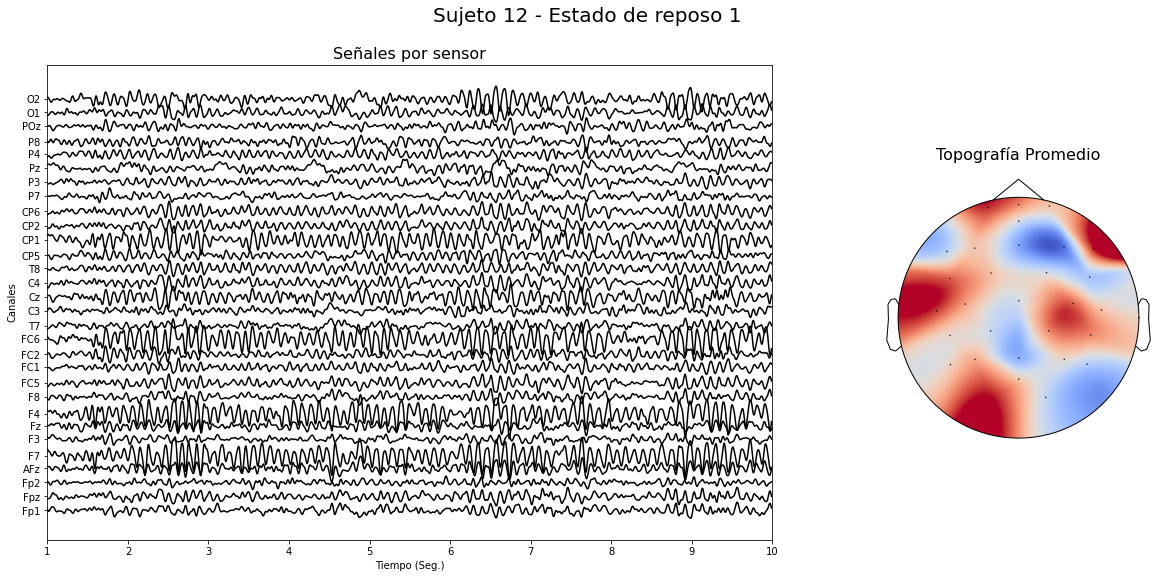

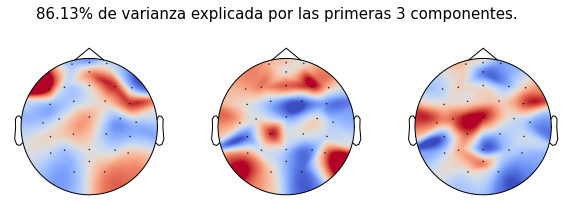

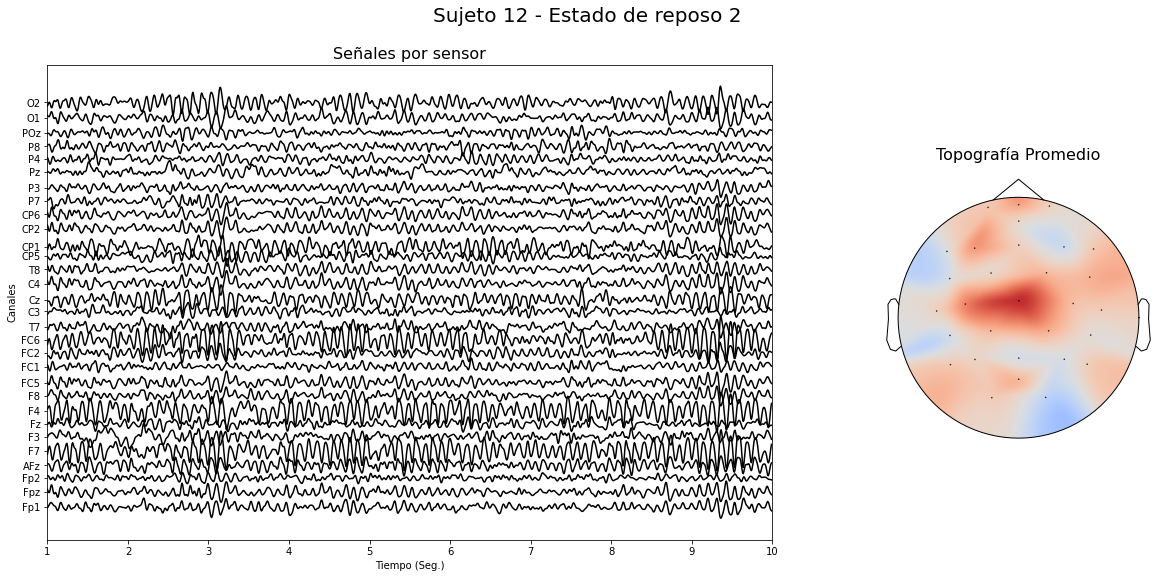

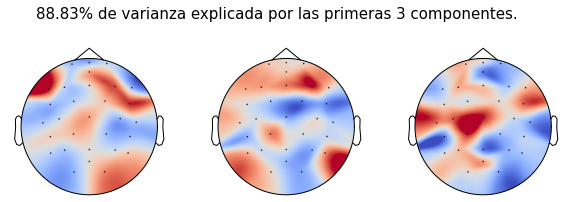

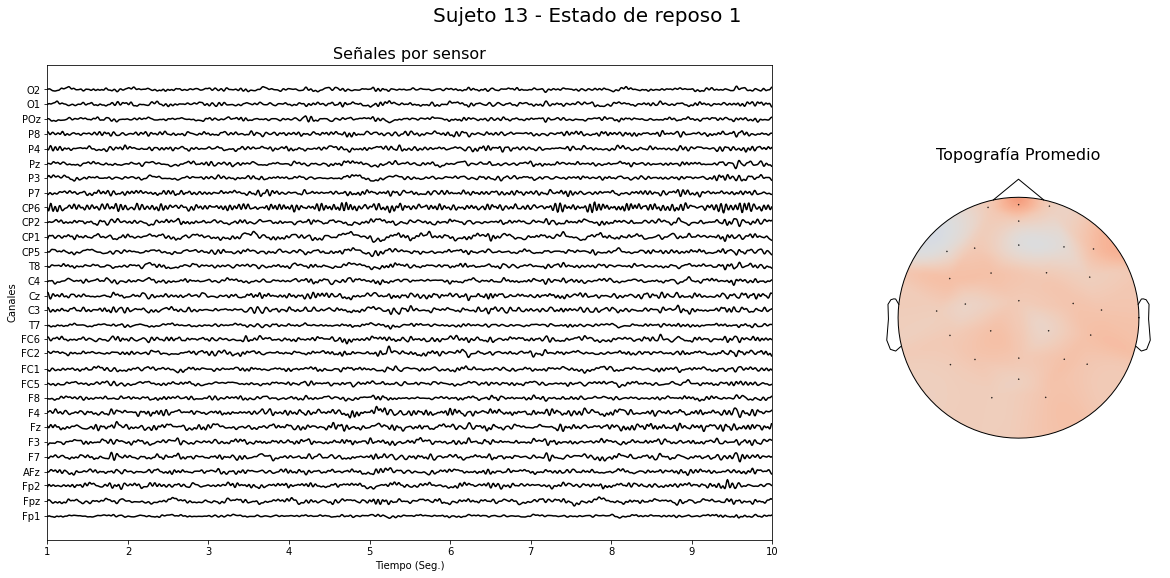

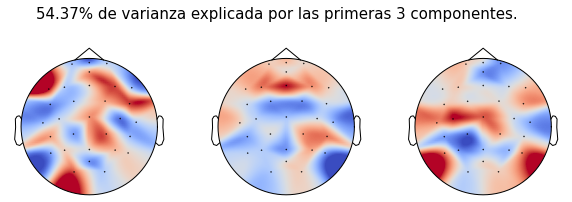

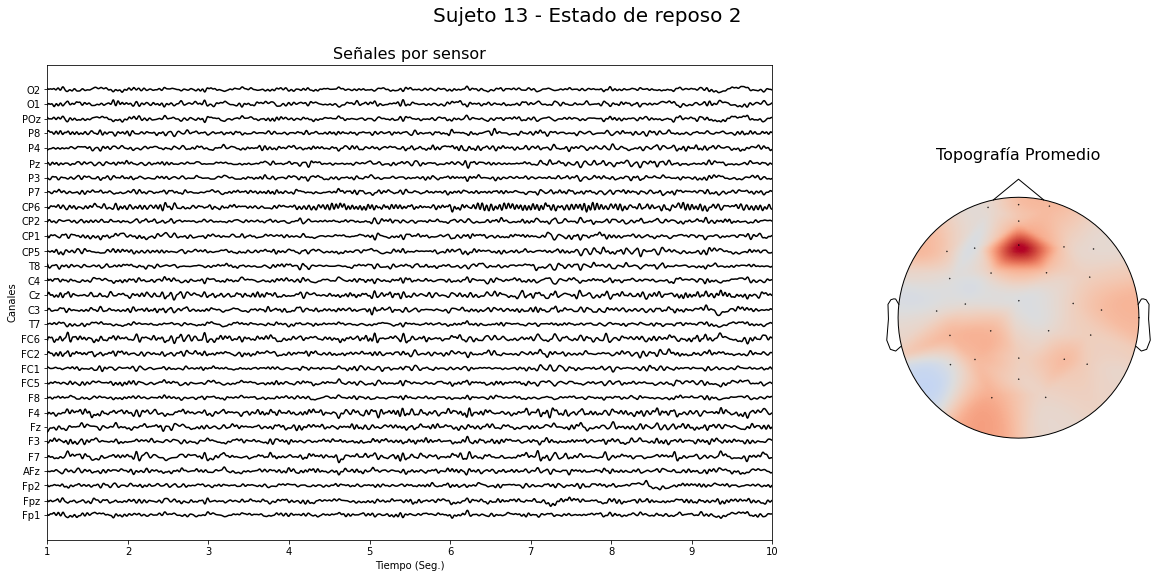

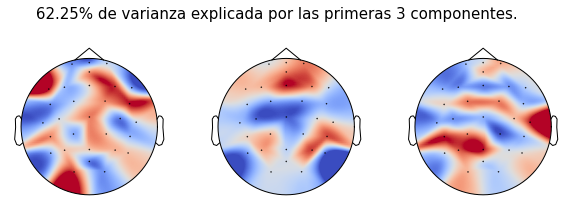

In [11]:
info_eeg, montage = get_info_eeg_and_montage()

plot_eegs_summary(eegs, info_eeg, montage)

In [12]:
promedios_totales = eegs_total_mean(eegs)

print(promedios_totales.max(axis=None))
print(promedios_totales.min(axis=None))

0.01997477326822899
-0.02942990907942702


Todos los promedios dan cercanos a 0 porque los datos procesados tienen filtrada las bajas frecuencias. 

In [13]:
print(promedios_totales.max(axis=1))
print(promedios_totales.min(axis=1))

[0.01100957 0.0092637  0.01961749 0.00627234 0.01815815 0.01997477
 0.01143988 0.01742602 0.00538763 0.00713698]
[-0.02093899 -0.01089066 -0.02586782 -0.00552607 -0.00970843 -0.00530727
 -0.00937769 -0.02942991 -0.00441476 -0.00891953]


In [14]:
eegs_subject=order_asc_by_subject(eegs)
eegs_resting_state=order_asc_by_resting_state(eegs)

Análisis de componentes principales - distinguiendo por resting_state -  resting_state=1

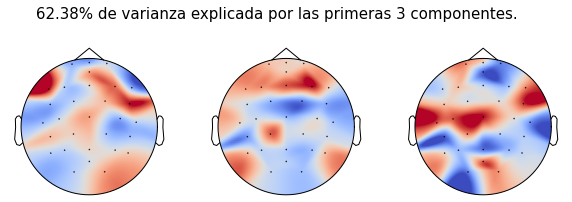

In [15]:
plot_eeg_pca(info_eeg, np.transpose(concat_fields(eegs_resting_state[0:5], data_field)))

Análisis de componentes principales - distinguiendo por resting_state -  resting_state=2

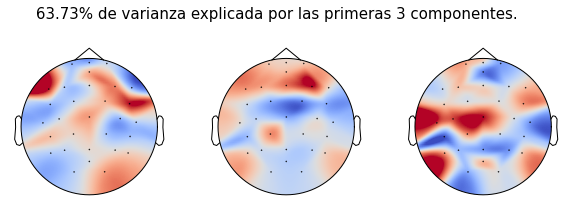

In [16]:
plot_eeg_pca(info_eeg, np.transpose(concat_fields(eegs_resting_state[5:], data_field)))

Los registros fueron tomados con el montage 10-20.
Tengo que armarlo que los electrodos tengan esta distribución:
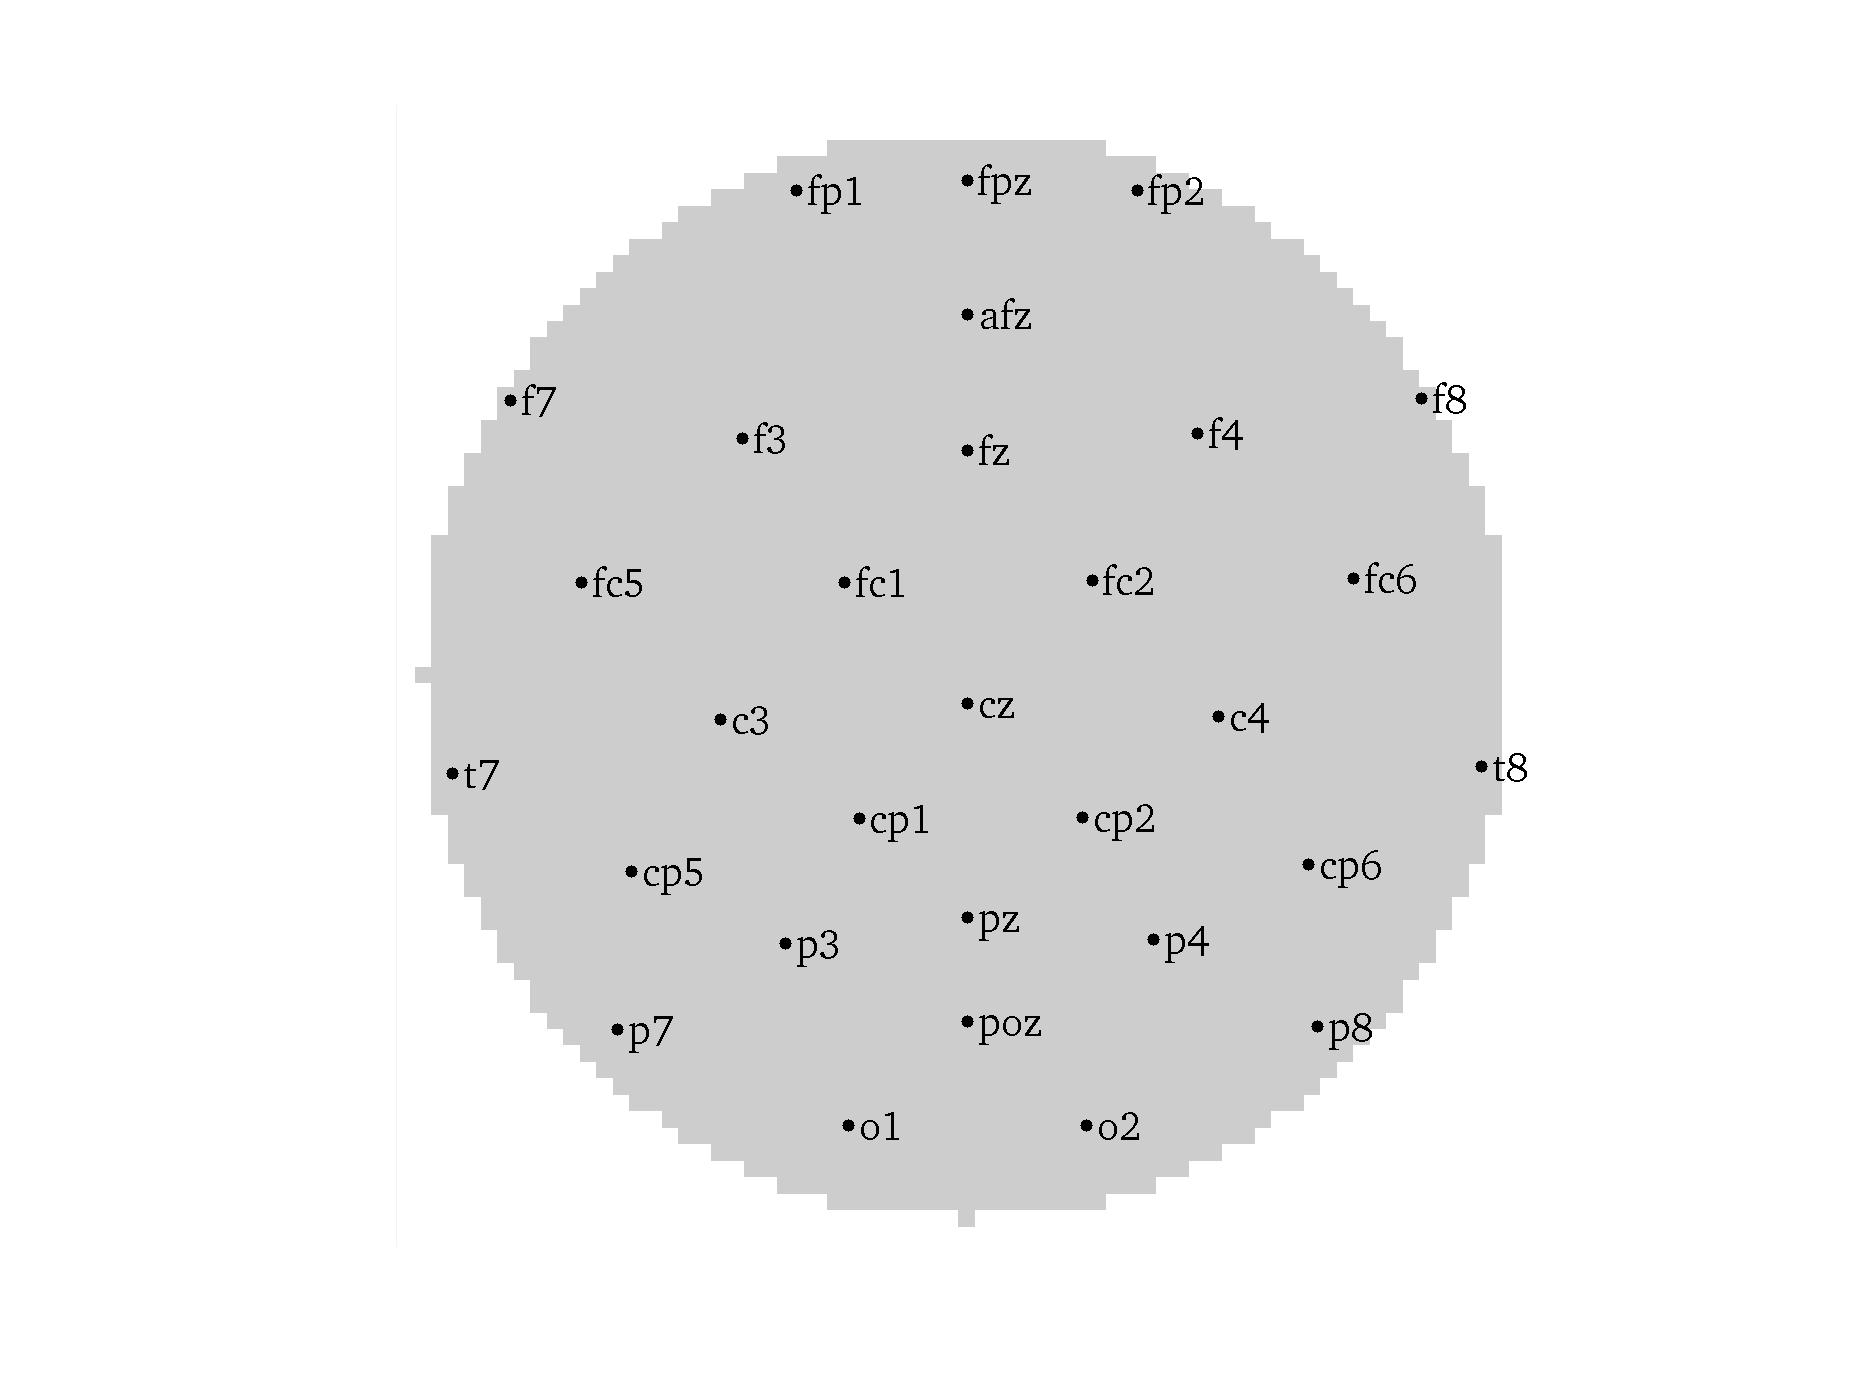

# 6. Obtención de GFP - Tarea 1

Para los cálculos a continuación uso ref https://link.springer.com/content/pdf/10.1007/s10548-008-0054-5.pdf.

Siendo la media $\bar{u}=\frac{1}{c}\sum_{i=1}^{c}{u_{i}}$   donde $c$ es la cantidad total de canales y $u_{i}$ es la medición del i-ésimo canal.

El *average reference* se calcula $v_i=u_i-\bar{u}$ \\
El *Global field power* (GFP) se calcula como 
$GFP(n)=\sqrt{\frac{1}{c}\sum_{i=1}^{c}v_{i}^2}$ (para cada tiempo *t* o muestra *n*).
Los picos de GCP se encuentran con la función find_peaks. Para evitar que estén demasiado próximos entre sí se elige el parámetro distancia.
Por ejemplo eligiendo distance=8 y con la frecuencia de muestreo de 128 Hz los picos deberán estar alejados en no menos de 60 ms (aproximadamente).

Para cada indice identificados del máximo de GCP se calcula cuanto vale $v_{i}$.

Antes distance=8 y prominence=1, si se dejan iguales a 1 y 0 respectivamente coinciden la cantidad de picos con lo obtenido en la función locmax de Frederic (13135).
  

- Cantidad de picos de GFP: 13135
- El intervalo temporal entre máximos de GFP promedio es: 45.684744746459565 ms
- El intervalo temporal entre máximos de GFP más chico es: 15.625 ms
- El intervalo temporal entre máximos de GFP más grande es: 242.1875 ms


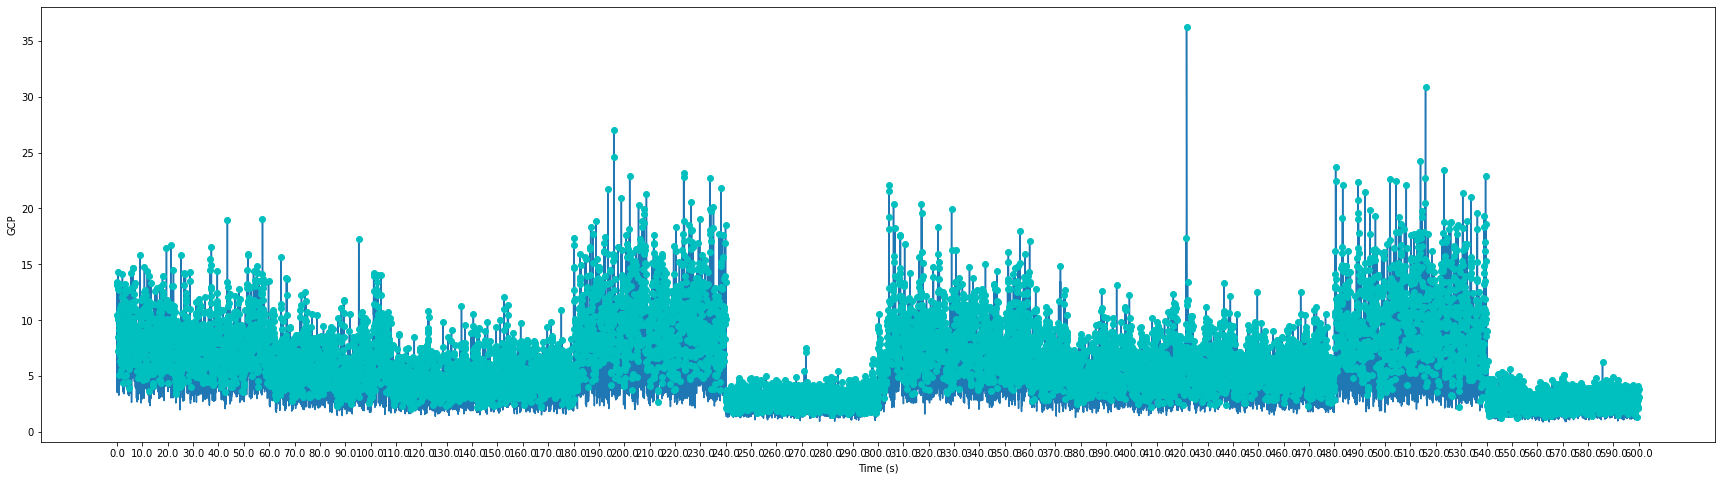

In [17]:
gfp, peaks, v_i_peaks, gfp_values, gfp2, n_gfp = find_gfp_peaks(
    eeg_data   = concat_fields(eegs_resting_state, data_field), 
    prominence = 0, 
    distance   = 1,
    height     = 0
)

show_complete_gfp_peaks_summary(
    gfp, 
    peaks, 
    sfrequency = eegs[0].sfrequency
)

In [18]:
data = np.transpose(v_i_peaks)
data.shape

(13135, 30)

In [19]:
df = pd.DataFrame(data, columns=montage.ch_names)

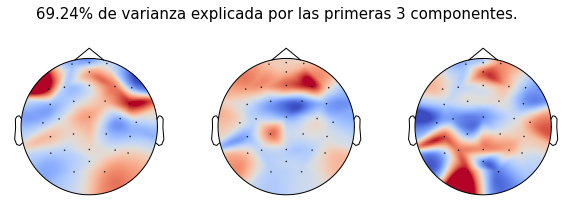

In [20]:
plot_eeg_pca(info_eeg, np.transpose(df))

### Alternativa de Reducción de ruido vía PCA (Tarea 1)

Se calcula la matriz de PCA y se toman pocas componentes, luego se recompone la señal y se compara visualmente con la señal original de los canales.  Esta reducción se puede incluir en la función de búsqueda de GFP.

In [21]:
Xnl,acum=reduce_noise_pca(v_i_peaks,8)

In [22]:
acum

array([0.47335095, 0.59974586, 0.69241116, 0.76631523, 0.80769363,
       0.84044434, 0.86322781, 0.88313739])

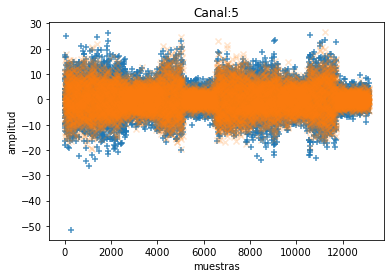

In [23]:
nro_canal=5
plot_sx_reduce_noise(v_i_peaks,Xnl,5)

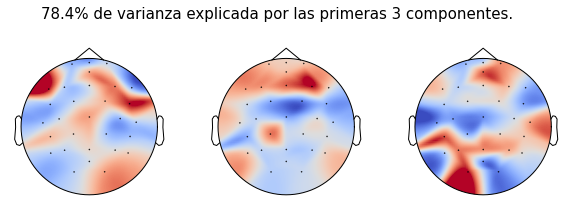

In [24]:
df = pd.DataFrame(Xnl.T, columns=montage.ch_names)
plot_eeg_pca(info_eeg, np.transpose(df))

Si decidimos sacar los 

In [25]:
Xnl,acum=reduce_noise_pca(np.transpose(concat_fields(eegs_resting_state, data_field)),12)

In [26]:
acum

array([0.40531519, 0.53572948, 0.62918945, 0.69932145, 0.74547039,
       0.78472106, 0.8128532 , 0.83766169, 0.85757905, 0.8760784 ,
       0.89063275, 0.90315737])

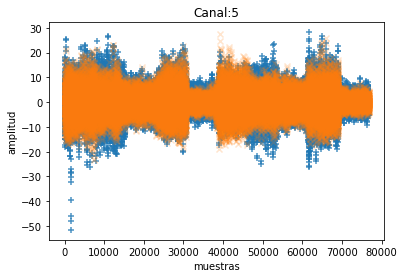

In [27]:
nro_canal=3
plot_sx_reduce_noise(np.transpose(concat_fields(eegs_resting_state, data_field)),Xnl,5)

- Cantidad de picos de GFP: 13053
- El intervalo temporal entre máximos de GFP promedio es: 45.971761990499544 ms
- El intervalo temporal entre máximos de GFP más chico es: 15.625 ms
- El intervalo temporal entre máximos de GFP más grande es: 242.1875 ms


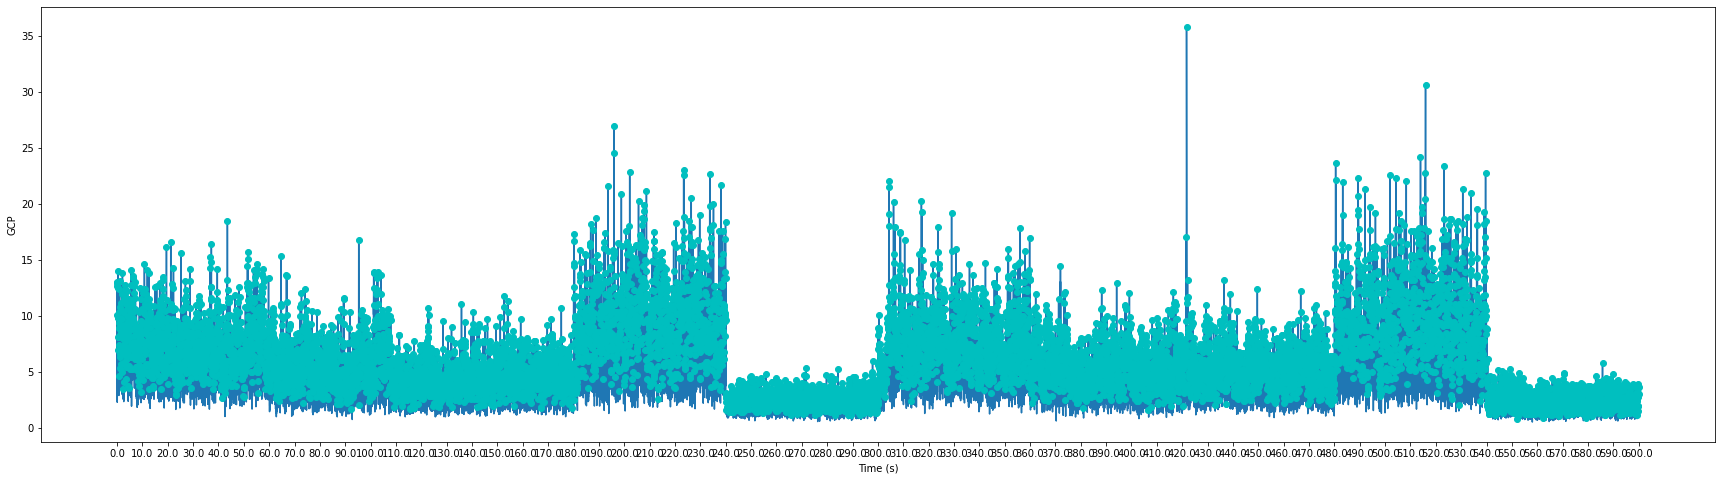

In [28]:
gfp, peaks, v_i_peaks, gfp_values, gfp2, n_gfp = find_gfp_peaks(
    eeg_data   = Xnl.T, 
    prominence = 0, 
    distance   = 1,
    height     = 0
)

show_complete_gfp_peaks_summary(
    gfp, 
    peaks, 
    sfrequency = eegs[0].sfrequency
)

# 7. Cálculo de *kmeans* modificado - Tarea 2 

Mapas usados en todas las funciones a continuación:

In [29]:
X=v_i_peaks

*kmeans_gfp*

In [30]:
#n_clusters = 2
#maps_kmeans,labels_gfp,cv,gev,gev_sum = kmeans2(X, gfp,peaks, n_clusters, n_runs=100, maxerr=1e-6, maxiter=500)

labels_gfp es un vector del mismo largo que gfp con el label del cluster.

maps_kmeans tiene dimensiones de cantidad de clusters por 30 canales

In [33]:
eeg1 = eegs[1].to_dict()
ch   = eeg1['nchannels']

In [36]:
cv_list, gev_list, sil_list = [], [], [] 

for k in range(2,11):
    maps_kmeans, labels_gfp, cv, _, gev_sum = kmeans2(X, gfp,peaks, k, n_runs=100, maxerr=1e-6, maxiter=500)
    sil_mean = np.mean(silhoutte_modificado2(maps_kmeans, X,labels_gfp, ch, k))
    cv_list.append(cv)
    gev_list.append(gev_sum)
    sil_list.append(sil_mean)

cv_list, gev_list, sil_list

	K-means run 55/100 did NOT converge after 500 iterations.
	K-means run 55/100 did NOT converge after 500 iterations.
	K-means run 55/100 did NOT converge after 500 iterations.
	K-means run 55/100 did NOT converge after 500 iterations.
	K-means run 81/100 did NOT converge after 500 iterations.
	K-means run 81/100 did NOT converge after 500 iterations.
	K-means run 81/100 did NOT converge after 500 iterations.
	K-means run 81/100 did NOT converge after 500 iterations.
	K-means run 1/100 did NOT converge after 500 iterations.
	K-means run 1/100 did NOT converge after 500 iterations.
	K-means run 1/100 did NOT converge after 500 iterations.
	K-means run 1/100 did NOT converge after 500 iterations.
	K-means run 52/100 did NOT converge after 500 iterations.
	K-means run 52/100 did NOT converge after 500 iterations.
	K-means run 52/100 did NOT converge after 500 iterations.
	K-means run 52/100 did NOT converge after 500 iterations.
	K-means run 3/100 did NOT converge after 500 iterations.
	K

([23.2013642551278,
  21.469069839439996,
  20.722513693716177,
  20.621457332229593,
  21.151688490802705,
  21.82662521823842,
  22.961758435178496,
  24.35297332103562,
  26.12141947323858],
 [0.1530426477923079,
  0.16762327118804773,
  0.17710707439272375,
  0.18362744207000956,
  0.18781062240396634,
  0.1916064407578632,
  0.1942673851917305,
  0.1966040601601214,
  0.19849595747235382],
 [0.21182879271386387,
  0.2069959119380791,
  0.2635385297937913,
  0.23314540039113923,
  0.2293631945379217,
  0.22541320078401236,
  0.21271476397092376,
  0.20488177586969228,
  0.21670247352766336])

Text(0, 0.5, 'cv')

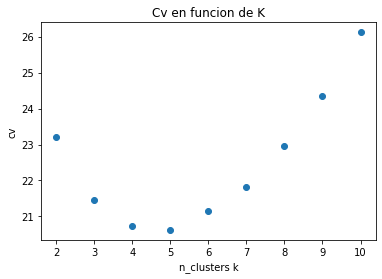

In [37]:
labels_clusters = range(2,11)
plt.plot(labels_clusters,cv_list,'o')
plt.title("Cv en funcion de K")
plt.xlabel("n_clusters k")
plt.ylabel("cv")

Text(0, 0.5, 'silhoutte')

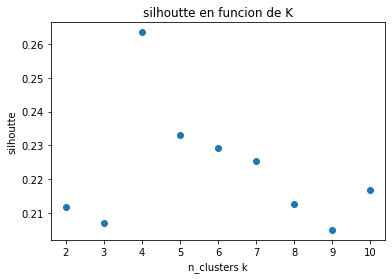

In [38]:
plt.plot(labels_clusters,sil_list,'o')
plt.title("silhoutte en funcion de K")
plt.xlabel("n_clusters k")
plt.ylabel("silhoutte")

Text(0, 0.5, 'gev')

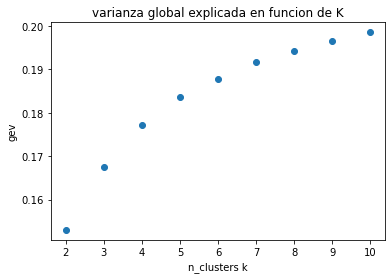

In [39]:
plt.plot(labels_clusters,gev_list,'o')
plt.title("varianza global explicada en funcion de K")
plt.xlabel("n_clusters k")
plt.ylabel("gev")

In [40]:
n_clusters=5

In [41]:
maps_kmeans,labels_gfp,cv,_,gev_sum = kmeans2(X, gfp,peaks, n_clusters, n_runs=100, maxerr=1e-6, maxiter=500)

For n_clusters = 5 The average silhouette_score is : 0.23461443105280855


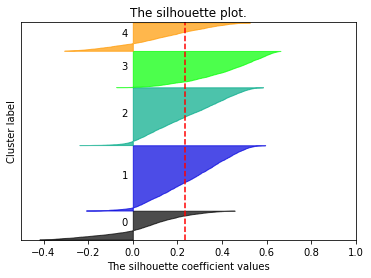

In [42]:
sil = silhoutte_modificado2(
    maps_kmeans, 
    X,
    labels_gfp, 
    ch,
    n_clusters
)

plot_silhoutte_modificado2(n_clusters, sil, labels_gfp)

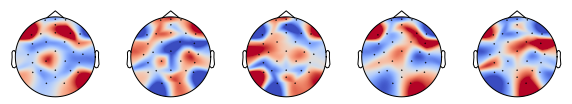

In [43]:
plot_maps_pca(maps_kmeans,n_clusters,info_eeg)

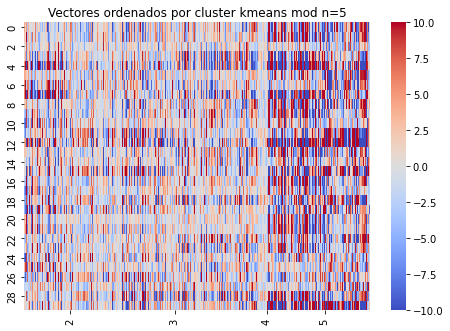

In [44]:
plot_vectores_kmeans(X,labels_gfp,n_clusters)

In [45]:
gfp2 = np.sum(gfp**2) # normalizing constant
gev2,gev_sum2=calculo_gev(X,maps_kmeans,30,4,gfp_values,gfp2,labels_gfp) #revisar valores

C.shape: 130535


In [47]:
print(gev_sum)
# print(gev) # es el gev para cada uno de los prototipos del cluster

0.18362929791276913


# Cálculo con otros métodos. Tarea 3

### Nuevos modelos

*Kmeans - clásico*

In [48]:
kmeans = KMeans(n_clusters,random_state=0).fit(X.T)
labels_kmeans_clasico=kmeans.labels_

In [49]:
silhouette_avg = silhouette_score(X.T, labels_kmeans_clasico)
silhouette_avg

0.17160447814370602

In [50]:
sample_silhouette_values = silhouette_samples(X.T, labels_kmeans_clasico)
sample_silhouette_values

array([0.17567176, 0.1784    , 0.19976057, ..., 0.11244007, 0.13353156,
       0.21046401])

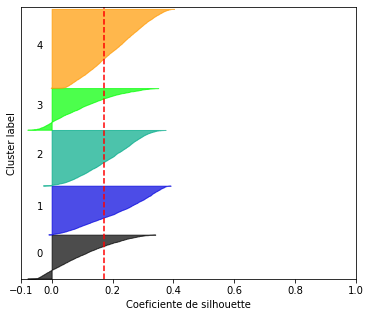

In [51]:
plot_silhoutte(
    df, 
    labels_kmeans_clasico,
    n_clusters, 
    sample_silhouette_values,
    silhouette_avg
)

*KMedoids*

In [54]:
KM_meta = KMedoids(
    n_clusters=n_clusters,
    init='k-medoids++'
).fit(X.T)

print(np.unique(KM_meta.labels_))
print(KM_meta.medoid_indices_)

[0 1 2 3 4]
[11285 11178  2337  9132 10040]


In [58]:
print(silhouette_score(X.T,KM_meta.labels_,metric='euclidean'))

0.16419632702367054


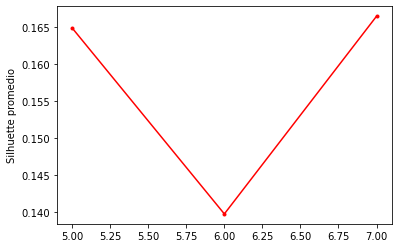

In [61]:
range_k = [i for i in range(5,8)]
silh = []
sse = []
for k in range_k:
    #KM_meta = KMedoids(n_clusters=k,metric='precomputed',init='k-medoids++').fit(X.T)
    KM_meta = KMedoids(n_clusters=k,metric="euclidean",init='heuristic').fit(X.T)

    silh.append(silhouette_score(X.T,KM_meta.labels_,metric='euclidean'))
    # sse.append(calcula_sse_kmedoids(KM_meta,X.T))

plt.plot(range_k,silh,'r.-')
plt.ylabel('Silhuette promedio')
plt.show()

# plt.plot(range_k,sse,'r.-')
# plt.ylabel('SSE')
# plt.show()

### Evaluación de modelos

In [62]:
# DataFrame with labels
tmp = pd.DataFrame({
    'Labels_kmeans_gfp': labels_gfp, 
    'Labels_kmeans_clasico': labels_kmeans_clasico
})

# crosstab: ct
ct0 = pd.crosstab(tmp['Labels_kmeans_gfp'], tmp['Labels_kmeans_clasico'])
ct0

Labels_kmeans_clasico    0     1     2    3     4
Labels_kmeans_gfp                                
0                      305   536    44  347   513
1                      980    63  1432  493   970
2                      576    50  1125  985   749
3                       18  1115     6   22  1021
4                      256   602    88  177   580

In [63]:
# DataFrame with labels
tmp = pd.DataFrame({
    'Labels_kmeans_gfp': labels_gfp, 
    'Labels_KMedoids': KM_meta.labels_
})

# crosstab: ct
ct1 = pd.crosstab(tmp['Labels_kmeans_gfp'], tmp['Labels_KMedoids'])
ct1

Labels_KMedoids      0    1    2     3     4     5    6
Labels_kmeans_gfp                                      
0                  275  747  107    33   535    34   14
1                  457   37  658  1322     7  1260  197
2                  986   92  474   726    23  1175    9
3                    2  575   17    14  1105     5  464
4                   27   27  159    55   617    25  793

Criterio VanDongen

In [64]:
van_dongen(ct0)

0.8597218434687756

In [65]:
van_dongen(ct1)

0.7165082108902333

Rand Score

In [66]:
ari0 = adjusted_rand_score(labels_gfp, labels_kmeans_clasico)
ari0

0.10390430840609424

In [67]:
ari1 = adjusted_rand_score(labels_gfp, KM_meta.labels_)
ari1

0.19546941364017426

### Validación Interna
distancias: conceptos de cohesión (cuán cerca están dentro de un cluster) y separación (cuán separados están los clusters)

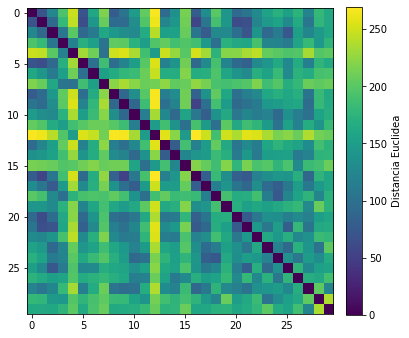

In [68]:
d = euclidean_distances(X, X)
plot_distancia_euclidea(d)

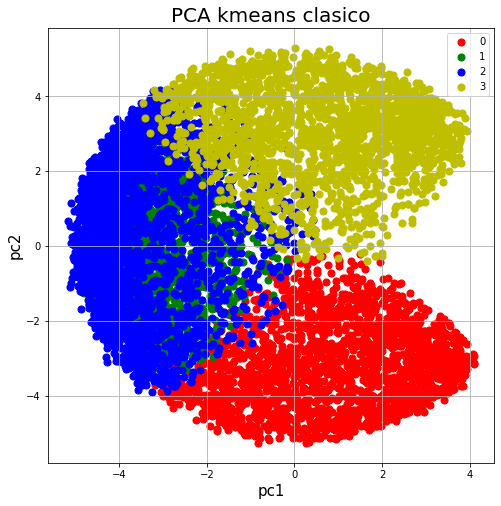

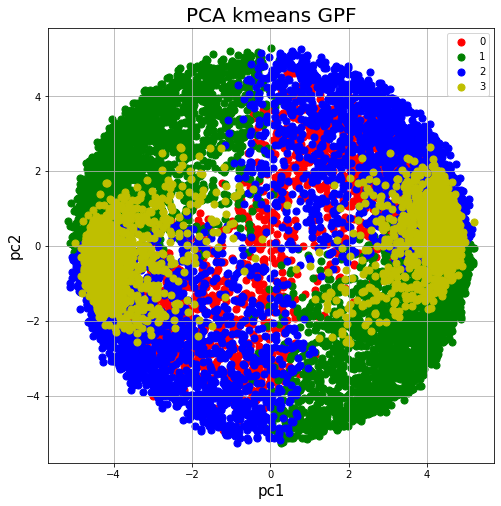

In [69]:
pca = PCA(n_components=2, n_jobs = 24)
pca_result = pca.fit_transform(X.T)

plot_pca_df(to_df(pca_result, labels_kmeans_clasico), title='PCA kmeans clasico')
plot_pca_df(to_df(pca_result, labels_gfp),    title='PCA kmeans GPF')

In [ ]:
tsne = TSNE(n_components=2, perplexity=1000, n_jobs = 24)
tsne_result = tsne.fit_transform(X.T)

plot_pca_df( to_df(tsne_result, labels_kmeans_clasico), title='TSNE kmeans GPF')

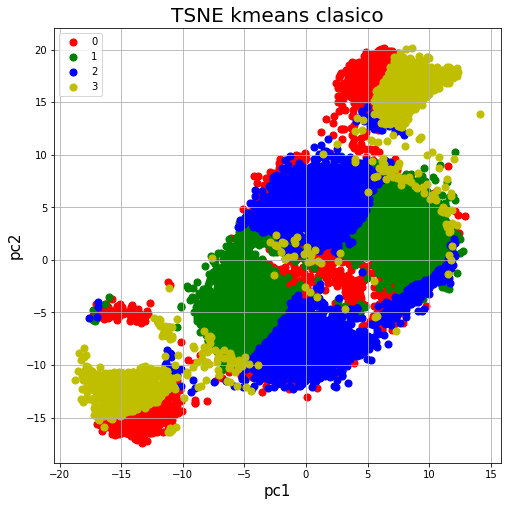

In [86]:
tsne = TSNE(n_components=2,perplexity=1000, n_jobs = 24)
tsne_result = tsne.fit_transform(X.T)

plot_pca_df(to_df(tsne_result, labels_gfp), title='TSNE kmeans clasico')

In [73]:
# mds = MDS(n_components=2, n_jobs = 24, eps=0.1, max_iter=100)
# mds_result = mds.fit_transform(X.T)

# plot_pca_df(to_df(mds_result, labels_kmeans_clasico), title='PCA kmeans clasico')
# plot_pca_df(to_df(mds_result, labels_gfp),    title='PCA kmeans GPF')

In [ ]:
isomap = Isomap(n_components=2, n_neighbors=4, n_jobs = 24, max_iter = 100)
isomap_result = isomap.fit_transform(X.T)

plot_pca_df(to_df(isomap_result, labels_kmeans_clasico), title='Isomap kmeans clasico')
plot_pca_df(to_df(isomap_result, labels_gfp), title='Isomap kmeans GPF')

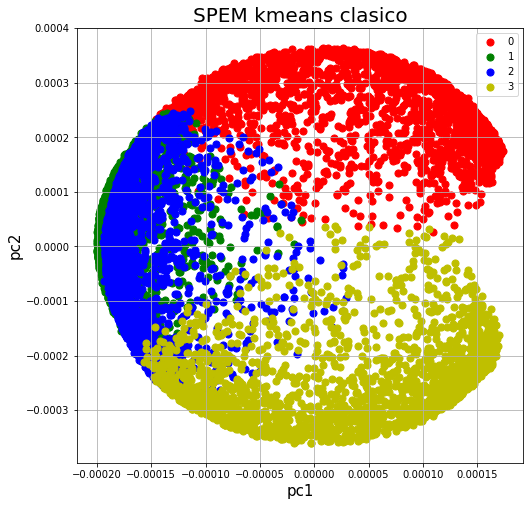

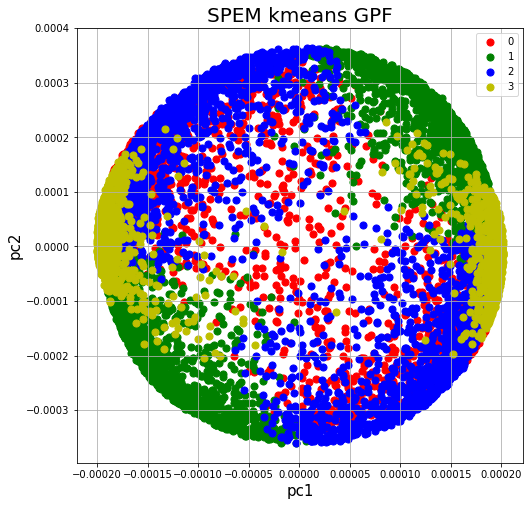

In [85]:
spem = SpectralEmbedding(n_components=2, n_neighbors=3000, n_jobs = 24)
spem_report = spem.fit_transform(X.T)

plot_pca_df(to_df(spem_report, labels_kmeans_clasico), title='SPEM kmeans clasico')
plot_pca_df(to_df(spem_report, labels_gfp), title='SPEM kmeans GPF')